In [16]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
import torch.distributions as D

import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        mu = self.fc(x)
        return mu
    
def init_normal(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight)
        m.bias.data.fill_(0.001)

In [145]:
def kl_loss_funct(mu_i, std_i, mu_j, std_j):
    
    p_i = D.independent.Independent(D.normal.Normal(mu_i, std_i), 1)
    p_j = D.independent.Independent(D.normal.Normal(mu_j, std_j), 1)

    z_i = p_i.rsample()
    z_j = p_j.rsample()

    kl_1_2 = p_i.log_prob(z_i) - p_j.log_prob(z_i)
    kl_2_1 = p_j.log_prob(z_j) - p_i.log_prob(z_j)
    
    kl_loss = (kl_1_2 + kl_2_1).mean() / 2
    return kl_loss

In [149]:
def simulate():
    mu1 = 0.
    mu2 = 0.5
    std1 = 1.
    std2 = 1.5

    x_i = torch.randn(32, 1, 256)
    x_j = (x_i + mu2) * std2

    mi = 1/2 *(np.log(1. + ( 1/(std2 ** 2) )))
    kl = np.log(std2 / std1) + (std1 ** 2 + (mu1 - mu2) ** 2) / (2 * std2 ** 2) - 0.5

#     print('The theoretical mi: {}'.format(mi))
#     print('The theoretical kl: {}'.format(kl))

    mu_i = torch.mean(x_i, 2)
    std_i = torch.std(x_i, 2)

    mu_j = torch.mean(x_j, 2)
    std_j = torch.std(x_j, 2)

    kl1 = kl_loss_funct(mu_i, std_i, mu_j, std_j)
#     print('The kl func: {}'.format(kl1))

    model = SimpleNet()
    model.apply(init_normal)

    mu_i = model(x_i).detach().squeeze(1)
    mu_j = model(x_j).detach().squeeze(1)

    kl2 = kl_loss_funct(mu_i, std_i, mu_j, std_j)
#     print('The kl model func: {}'.format(kl2))
    return kl1, kl2


all_kl1 = []
all_kl2 = []
for _ in range(1000):
    kl1, kl2 = simulate()
    all_kl1.append(kl1)
    all_kl2.append(kl2)

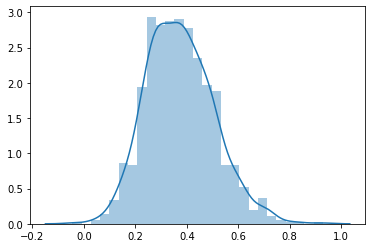

In [150]:
sns.distplot(all_kl1)

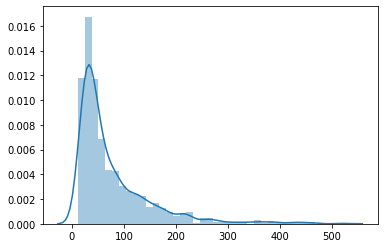

In [151]:
sns.distplot(all_kl2)

In [155]:
model = SimpleNet()
model.apply(init_normal)
n_epoch = 1000

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

kl_hist = []
for epoch in range(n_epoch):

    mu1 = 0.
    mu2 = 0.5
    std1 = 1.
    std2 = 1.5

    x_i = torch.randn(32, 1, 256)
    x_j = (x_i + mu2) * std2
    
    mu_i = model(x_i).squeeze(1)
    mu_j = model(x_j).squeeze(1)
    
    std_i = torch.std(x_i, 2)
    std_j = torch.std(x_j, 2)

    kl2 = kl_loss_funct(mu_i, std_i, mu_j, std_j)

    model.zero_grad()
    kl2.backward()
    optimizer.step()
    
    kl_hist.append(kl2.item())


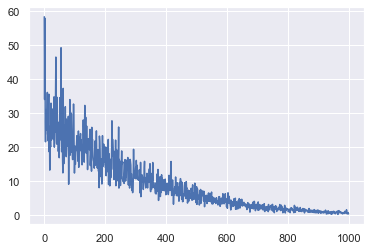

In [157]:
sns.set()
plt.plot(kl_hist)